In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss


# **Fitting Flood Frequency Model in James River:**

**Calculating the annual maxima from the daily streamflow data:**

THE ANNUAL MAXIMA FLOW TABLE:


,Date,Flow
Year,,
1924,1924-12-31,68000.0
1925,1925-12-31,23500.0
1926,1926-12-31,38100.0
1927,1927-12-31,37700.0
1928,1928-12-31,67700.0
...,...,...
2015,2015-12-31,35400.0
2016,2016-12-31,36100.0
2017,2017-12-31,52900.0


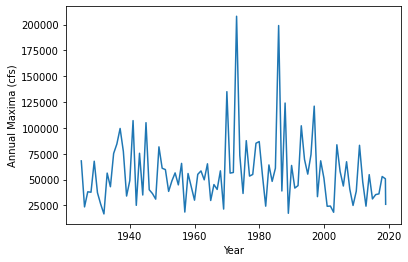

In [ ]:
allQ = pd.read_csv('James_Scottsville.csv')
# convert first column to date
allQ['Date'] = pd.to_datetime(allQ['Date'],format="%Y-%m-%d")
allQ['Flow'] = pd.to_numeric(allQ['Flow'],errors='ignore')

# find year of each data point
allQ['Year'] = allQ['Date'].dt.year
maxQ = allQ.groupby('Year').max()
plt.figure()
plt.plot(maxQ['Date'], maxQ['Flow'])
plt.xlabel('Year')
plt.ylabel('Annual Maxima (cfs)')
print('THE ANNUAL MAXIMA FLOW TABLE:')
maxQ


**Fitting Gumbel distribution to the annual maxima using both Method of Moments (MOM) and Max. Likelihood Estimates (MLE) to estimate 100 year and 500 year events in James River:**

In [ ]:
from scipy.stats import gumbel_r

def fitGumbell(data, method):
    assert method == 'MLE' or method == 'MOM',"method must = 'MLE' or 'MOM'"

    if method == 'MLE':
      xi, alpha = gumbel_r.fit(data) 
        
    elif method == 'MOM':
      alpha = np.sqrt(6)/np.pi * np.std(data)
      xi = np.mean(data) - np.euler_gamma*alpha           
    return xi, alpha

<Figure size 432x288 with 0 Axes>

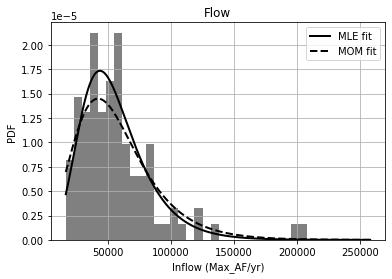

FOR GUMBEL MLE FIT:
- shape= 43785.0, scale= 21213.58

 FOR GUMBEL MOM FIT:
- shape= 42299.0, scale= 25393.51


In [ ]:
#histogram
plt.figure()
maxQ.hist(bins=30, color='gray', density=True)

#Gumbel pdf
xi_MLE,alpha_MLE = fitGumbell(maxQ['Flow'], 'MLE')
xi_MOM,alpha_MOM = fitGumbell(maxQ['Flow'], 'MOM')
x = np.arange(min(maxQ['Flow']),max(maxQ['Flow'])+50000, 10) # points to plot at
pdf_MLE= gumbel_r.pdf(x, xi_MLE, alpha_MLE)
cdf_MLE= gumbel_r.cdf(x, xi_MLE, alpha_MLE)
pdf_MOM= gumbel_r.pdf(x, xi_MOM, alpha_MOM)
cdf_MOM= gumbel_r.cdf(x, xi_MOM, alpha_MOM)
plt.plot(x, pdf_MLE, color='k', linewidth=2, label='MLE fit')
plt.plot(x, pdf_MOM, color='k', linewidth=2, linestyle='dashed',label='MOM fit')
plt.xlabel('Inflow (Max_AF/yr)')
plt.ylabel('PDF')
plt.legend()
plt.show()

#Printing Parameter values:
print('FOR GUMBEL MLE FIT:')
print('- shape= '+str(np.round(xi_MLE,0))+ ', scale= '+str(np.round(alpha_MLE,2)))

print('\n FOR GUMBEL MOM FIT:')
print('- shape= '+str(np.round(xi_MOM,0))+ ', scale= '+str(np.round(alpha_MOM,2)))


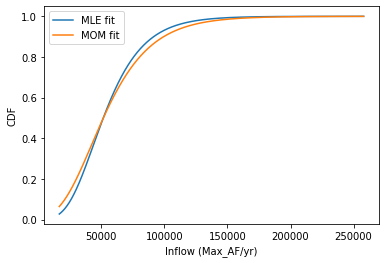

In [ ]:
plt.figure()
plt.plot(x,cdf_MLE,label='MLE fit')
plt.plot(x,cdf_MOM,label='MOM fit')
plt.xlabel('Inflow (Max_AF/yr)')
plt.ylabel('CDF')
plt.legend()
plt.show()


In [ ]:
hundred_year_MLE = x[np.where(cdf_MLE > 0.99)[0][0]]
five_hundred_year_MLE = x[np.where(cdf_MLE > 0.998)[0][0]]
hundred_year_MOM = x[np.where(cdf_MOM > 0.99)[0][0]]
five_hundred_year_MOM = x[np.where(cdf_MOM > 0.998)[0][0]]
print('- 100-year flood from MLE fit= '+str(hundred_year_MLE)+' cfs')
print('- 500-year flood from MLE fit= '+str(five_hundred_year_MLE)+' cfs')
print('- 100-year flood from MOM fit= '+str(hundred_year_MOM)+' cfs')
print('- 500-year flood from MOM fit= '+str(five_hundred_year_MOM)+' cfs')

- 100-year flood from MLE fit= 141380.0 cfs
- 500-year flood from MLE fit= 175600.0 cfs
- 100-year flood from MOM fit= 159120.0 cfs
- 500-year flood from MOM fit= 200090.0 cfs


**Calculating 95% Confidence intervals for the calculated design events:**

Inorder to calculate the 95% confidence intervals, we can use the following formula:

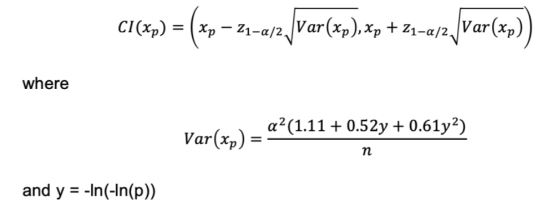

In [ ]:
#For 95% confidence interval:
a = 0.05
z = ss.norm.ppf(1-a/2)
n = len(maxQ)

# For 100 year flood:
p = 0.99
xp = hundred_year_MLE
y = -np.log(-np.log(p))
Var_xp = ((alpha_MLE**2)*(1.11 + 0.52*y + 0.61 *y**2))/n
hundred_year_lower = np.round(xp - z * np.sqrt(Var_xp), 3)
hundred_year_upper = np.round(xp + z * np.sqrt(Var_xp), 3)

# For 500 year flood:
p1 = 0.998
xp1 = five_hundred_year_MLE
y1 = -np.log(-np.log(p1))
Var_xp1 = ((alpha_MLE**2)*(1.11+0.52*y1+0.61*y1**2))/n
five_hundred_year_lower = np.round(xp1 - z * np.sqrt(Var_xp1), 3)
five_hundred_year_upper = np.round(xp1 + z * np.sqrt(Var_xp1), 3)

print('RESULTS:')
print('For a 100-year flow of '+str(xp)+' cfs, the confidence interval is:' '('+str(np.round(hundred_year_lower,0))+', '+str(np.round(hundred_year_upper,0))+') with a confidence band of '+str(np.round(hundred_year_upper-hundred_year_lower,0))+' cfs')
print('For a 500-year flow of '+str(xp1)+' cfs, the confidence interval is:' '('+str(np.round(five_hundred_year_lower,0))+', '+str(np.round(five_hundred_year_upper,0))+') with a confidence band of '+str(np.round(five_hundred_year_upper-five_hundred_year_lower,0))+' cfs')


RESULTS:
For a 100-year flow of 141380.0 cfs, the confidence interval is:(124190.0, 158570.0) with a confidence band of 34381.0 cfs
For a 500-year flow of 175600.0 cfs, the confidence interval is:(153189.0, 198011.0) with a confidence band of 44823.0 cfs


- As can be seen from the results above, the confidence band (upper bound - lower bound) is higher for the 500 year event, compared to that of the 100 year event. This is because as the return period goes up, the exceedence probability of an event gets lower, and the data available to make that flow estimate gets scarcer. The scarcer data results in low confidence on our flow estimate as reflected in the higher confidence band.

**Using a threshold of 50,000 cfs, we can identify peaks over the threshold and remove peaks within 5 days of each other, keeping only the maximum (to ensure independence of peak events):**

In [ ]:
# find only independent peaks
# if more than 1 peak over the threshold within 5 days of each other, pick only the largest
def findClusters(indices):
    allClusters = []
  
    subCluster = [indices[0]]
    for i in range(1,len(indices)):
        if indices[i] - subCluster[-1] <= 5:
            subCluster.append(indices[i])
        else:
            allClusters.append(subCluster)
            subCluster = [indices[i]]
           
    allClusters.append(subCluster)
    
    return allClusters

def findPeaks(clusters, data):
    peaks = np.zeros(len(clusters))
    for i in range(len(peaks)):
        peaks[i] = np.max(data[clusters[i]])
    
    return peaks

# find all peaks over the threshold, u
u = 50000
peak_indices = np.where(allQ['Flow'] > u)[0]
clusters= findClusters(peak_indices)
#clusters = np.array(clusters).reshape((1,-1))
peaks = findPeaks(clusters, allQ['Flow'])
print('INDEPENDENT PEAKS OVER THE THRESHOLD OF 50,000 CFS ARE:')
peaks

INDEPENDENT PEAKS OVER THE THRESHOLD OF 50,000 CFS ARE:


array([ 68000.,  67700.,  56200.,  75200.,  82700.,  84400.,  99400.,
        53400.,  53600.,  77200., 107000.,  75400.,  71800., 105000.,
        55100.,  81600.,  54900.,  60900.,  55100.,  59600.,  50900.,
        56400.,  65600.,  51800.,  55800.,  55000.,  52100.,  58300.,
        65200.,  58400., 135000.,  56200.,  56800., 208000.,  67500.,
        53000.,  53700.,  73400.,  87600.,  53300.,  54900.,  85100.,
        51400.,  51400.,  86700.,  55100.,  54600.,  51400.,  54000.,
        64100.,  60900., 199000., 124000.,  71200.,  67800.,  63600.,
       102000.,  69400.,  52900.,  55200.,  68600.,  74100., 121000.,
       114000.,  57400.,  68100.,  54100.,  50900.,  60000.,  51300.,
        83600.,  57800.,  67200.,  83100.,  50800.,  54700.,  52900.,
        50700.])

**Estimating the Poisson arrival rate of ﬂoods over the threshold:**

In [ ]:
Poisson_rate = np.round( len(peaks)/len(allQ), 4)
print('The Poisson arrival rate= '+str(Poisson_rate)+'/day, which means the average inter-arrival time between floods above 50,000 cfs is approximately '+str(np.round(1/Poisson_rate,0))+' days.')

The Poisson arrival rate= 0.0023/day, which means the average inter-arrival time between floods above 50,000 cfs is approximately 435.0 days.


**Fitting a Generalized Pareto (GP) distribution to the remaining peaks over the threshold using MLE:**

/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu



 
 FOR GENERAL PARETO DISTRIBUTION MLE FIT:
 shape= 0.0, loc= 50000, scale= 14623.25


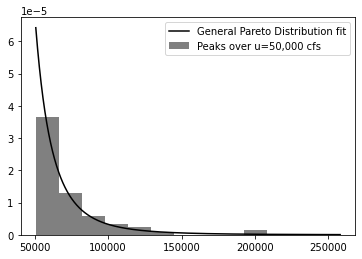

In [ ]:
# Fit a Generalized Pareto distribution 

from scipy.stats import genpareto
kappa, xi, alpha =genpareto.fit(peaks,floc=u)

x = np.arange(min(peaks),max(peaks)+50000, 1) # points to plot at
pdf_GPD = genpareto.pdf(x, kappa, xi, alpha )
cdf_GPD = genpareto.cdf(x, kappa, xi, alpha )

plt.figure()
plt.hist(peaks, bins=10, color='gray', density=True, label='Peaks over u=50,000 cfs')
plt.plot(x, pdf_GPD, color='k', label ='General Pareto Distribution fit')
plt.legend()

#Printing Parameters
print('\n \n FOR GENERAL PARETO DISTRIBUTION MLE FIT:')
print(' shape= '+str(np.round(kappa,0))+ ', loc= '+str(np.round(xi,2))+', scale= '+str(np.round(alpha,2)))

# **Fitting Drought Frequency Model (7Q10) in James River:**

**Using the ﬂow data from the James River at Scottsville, computing the annual minimum 7-day ﬂows and ﬁtting them to the Lognormal and Weibull distributions:**

In [ ]:
# Computing the annual minimum 7-day flows and appending them to the list Year_min
Year_min = []
day = 7
Years = [i for i in range(1924, 2019)]

for year in Years:
  Week_flow =[]

  while day< len(allQ) and allQ.iloc[day]['Year'] == year:
    flow = 0
    for i in range(day-7, day):
      flow += allQ.iloc[i]['Flow']
    Week_flow.append(flow)
    day +=1

  Year_min.append(min(Week_flow))


Note: The plot does not include data from 2019 because the flows were only recorded for January, causing the yearly minimum to be skewed.


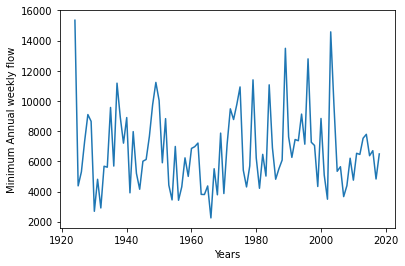

In [ ]:
plt.plot(Years, Year_min)
plt.ylabel('Minimum Annual weekly flow')
plt.xlabel('Years')

print('Note: The plot does not include data from 2019 because the flows were only recorded for January, causing the yearly minimum to be skewed.')

**(a) 2-parameter lognormal using MOM**

**(b) 2-parameter lognormal using MLE**

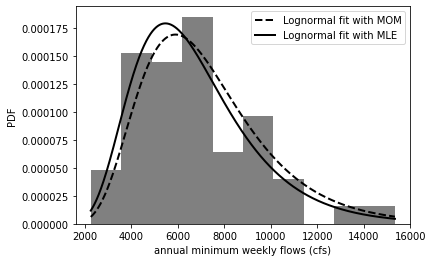

FOR LOGNORMAL MLE FIT:
- shape= 0.38 cfs, scale= 6308.0
- 7Q10 flow= 10270.0cfs.
- From K-S Test, D= 0.51

 FOR LOGNORMAL MOM FIT:
- shape= 0.37 cfs, scale= 6775.0
- 7Q10 flow= 10950.0cfs.
- From K-S Test, D= 0.56


In [ ]:
import math
from scipy import stats

#MOM moments
m, s = findMoments(Year_min)
mu = math.exp(np.log(m - 0.5*np.log(s**2/m**2+1)))
sigma= math.sqrt(np.log(s**2/m**2+1))

#MLE moments
sigma1,lo1c,mu1 = stats.lognorm.fit(Year_min,floc=0)

# plot histogram of data
plt.hist(Year_min, density=True, color='gray', edgecolor='none')

# plot the fitted pdf from MLE and MOM on top of the histogram
x = np.arange(min(Year_min),max(Year_min), 10) # points to plot at
pdf_MOM = stats.lognorm.pdf(x,sigma,0,mu)
pdf_MLE = stats.lognorm.pdf(x,sigma1,0,mu1)
cdf_MOM = stats.lognorm.cdf(x,sigma,0,mu)
cdf_MLE = stats.lognorm.cdf(x,sigma1,0,mu1)
plt.plot(x, pdf_MOM, color='k', linewidth=2, linestyle='dashed', label ='Lognormal fit with MOM')
plt.plot(x, pdf_MLE, color='k', linewidth=2, label ='Lognormal fit with MLE')
plt.xlabel('annual minimum weekly flows (cfs)')
plt.ylabel('PDF')
plt.legend()
plt.show()

#K-S Test:
D_MLE, p_MLE = stats.kstest(Year_min,'lognorm', args=[sigma1, mu1])
D_MOM, p_MOM = stats.kstest(Year_min,'lognorm', args=[sigma, mu])


#Calculating 7Q10 values
Q7_10_MLE = x[np.where(cdf_MLE > 0.9)[0][0]]
Q7_10_MOM = x[np.where(cdf_MOM > 0.9)[0][0]]

#Printing Parameter values , K-S test, 7Q10:
print('FOR LOGNORMAL MLE FIT:')
print('- shape= '+str(np.round(sigma1,2))+' cfs, scale= '+str(np.round(mu1,0)))
print('- 7Q10 flow= '+str(Q7_10_MLE)+ 'cfs.')
print('- From K-S Test, D= '+str(np.round(D_MLE,2)))

print('\n FOR LOGNORMAL MOM FIT:')
print('- shape= '+str(np.round(sigma,2))+' cfs, scale= '+str(np.round(mu,0)))
print('- 7Q10 flow= '+str(Q7_10_MOM)+ 'cfs.')
print('- From K-S Test, D= '+str(np.round(D_MOM,2)))

**(c) 2-parameter Weibull using MOM**

**(d) 2-parameter Weibull using MLE**

In [ ]:
from scipy.optimize import brentq as root
from math import gamma as GammaFN
from scipy.optimize import fsolve


# Fit a Weibull distribution. Note if you want the two-parameter Weibull, you have to set npars=2
def fitWeibull(data, method, npars):
    assert method == 'MLE' or method == 'MOM',"method must = 'MLE' or 'MOM'"
    assert npars == 2 or npars == 3,"npars must = 2 or 3"
    
    xbar, std = findMoments(data)

    if method == 'MLE':
        if npars == 2:
            kappa, xi, alpha = ss.weibull_min.fit(data,floc=0)
        elif npars == 3:
            kappa, xi, alpha = ss.weibull_min.fit(data)
    elif method == 'MOM':
        if npars == 2:
            kappa = root(lambda x: xbar**2 * (GammaFN(1+2/x)/GammaFN(1+1/x)**2 -1) - std**2, 0.02, 10)
            alpha = xbar / GammaFN(1+1/kappa)
            xi = 0
        elif npars == 3:
            def equations(p):
                kappa, xi, alpha = p
                mu = alpha*GammaFN(1+1/kappa) + xi
                sigma = np.sqrt(alpha**2*(GammaFN(1+2/kappa)-(GammaFN(1+1/kappa))**2))
                gamma = (GammaFN(1+3/kappa)*alpha**3 -3*mu*sigma**2 - mu**3)/(sigma**3)
                return (mu-xbar, sigma-std, gamma-skew)
            
            kappa = root(lambda x: xbar**2 * (GammaFN(1+2/x)/GammaFN(1+1/x)**2 -1) - std**2, 0.02, 10)
            alpha = xbar / GammaFN(1+1/kappa)
            xi = 0
            kappa, xi,alpha = fsolve(equations,(kappa,xi,alpha))
            
    return kappa, xi, alpha


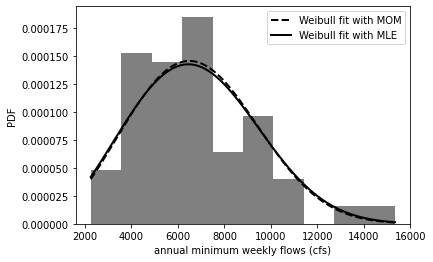

FOR WEIBULL MLE FIT:
- shape= 3.0, scale= 7621.33
- 7Q10 flow= 10350.0 cfs.
- From K-S Test, D= 0.72

 FOR WEIBULL MOM FIT:
- shape= 3.0, scale= 7609.52
- 7Q10 flow= 10260.0 cfs.
- From K-S Test, D= 0.71


In [ ]:
kappa_MOM, xi_MOM, alpha_MOM = fitWeibull(Year_min, 'MOM', 2)
kappa_MLE, xi_MLE, alpha_MLE = fitWeibull(Year_min, 'MLE', 2)

x = np.arange(min(Year_min),max(Year_min), 10) # points to plot at
pdf_MOM_w = stats.weibull_min.pdf(x, kappa_MOM, xi_MOM, alpha_MOM)
pdf_MLE_w = stats.weibull_min.pdf(x, kappa_MLE, xi_MLE, alpha_MLE)
cdf_MOM_w = stats.weibull_min.cdf(x, kappa_MOM, xi_MOM, alpha_MOM)
cdf_MLE_w = stats.weibull_min.cdf(x, kappa_MLE, xi_MLE, alpha_MLE)

# plot histogram of data
plt.hist(Year_min, density=True, color='gray', edgecolor='none')

# plot the fitted pdf from MLE and MOM on top of the histogram
plt.plot(x, pdf_MOM_w, color='k', linewidth=2, linestyle='dashed', label ='Weibull fit with MOM')
plt.plot(x, pdf_MLE_w, color='k', linewidth=2, label ='Weibull fit with MLE')
plt.xlabel('annual minimum weekly flows (cfs)')
plt.ylabel('PDF')
plt.legend()
plt.show()

#K-S Test:
D_MLE_w, p_MLE_w = stats.kstest(Year_min,'weibull_min', args=[kappa_MLE, alpha_MLE])
D_MOM_w, p_MOM_w = stats.kstest(Year_min,'weibull_min', args=[kappa_MOM, alpha_MOM])


#Calculating 7Q10 values
Q7_10_MLE_w = x[np.where(cdf_MLE_w > 0.9)[0][0]]
Q7_10_MOM_w = x[np.where(cdf_MOM_w > 0.9)[0][0]]


#Printing Parameter values, K-S Test, and 7Q10:
print('FOR WEIBULL MLE FIT:')
print('- shape= '+str(np.round(kappa_MLE,0))+ ', scale= '+str(np.round(alpha_MLE,2)))
print('- 7Q10 flow= '+str(Q7_10_MLE_w)+ ' cfs.')
print('- From K-S Test, D= '+str(np.round(D_MLE_w,2)))

print('\n FOR WEIBULL MOM FIT:')
print('- shape= '+str(np.round(kappa_MOM,0))+ ', scale= '+str(np.round(alpha_MOM,2)))
print('- 7Q10 flow= '+str(Q7_10_MOM_w)+ ' cfs.')
print('- From K-S Test, D= '+str(np.round(D_MOM_w,2)))

The summary of K-S Test on the distributions is shown below:

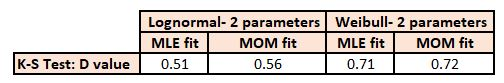

- Although theoretically, Weibull distribution is expected to fit the series of minimas better, we can see from the D vaues of K-S test that Lognormal, for both fitting methods, seems to perform better than Weibull. This finding is also consistent with the visual inspection of the fits, where we can see Lognormal distributions seems to capture the peaks better than Weibull. Furthermore, in terms of the fitting methods, MLE seems to work better for Lognormal fit, whereas MOM method is better for Weibull for fitting our sample.